#### Imports


In [1]:
from zoish.feature_selectors.shap_selectors import ShapFeatureSelector
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from category_encoders import OrdinalEncoder
import xgboost
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from sklearn.linear_model import LinearRegression

In this module the default logging will be applied.


#### Computer Hardware Data Set (a regression problem)
  
###### https://archive.ics.uci.edu/ml/datasets/Computer+Hardware

In [2]:
urldata= "https://archive.ics.uci.edu/ml/machine-learning-databases/cpu-performance/machine.data"
# column names
col_names=[
    "vendor name",
    "Model Name",
    "MYCT",
    "MMIN",
    "MMAX",
    "CACH",
    "CHMIN",
    "CHMAX",
    "PRP"
]
# read data
data = pd.read_csv(urldata,header=None,names=col_names,sep=',')


#### Train test split

In [3]:
X = data.loc[:, data.columns != "PRP"]
y = data.loc[:, data.columns == "PRP"]


X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.33, random_state=42)


#### Define feature selector step 


In [4]:
shap_feature_selector_factory = (
    ShapFeatureSelector.shap_feature_selector_factory.set_model_params(
        X=X_train,
        y=y_train,
        verbose=10,
        random_state=0,
        estimator=xgboost.XGBRegressor(),
        estimator_params={
            "max_depth": [4, 5],
        },
        fit_params = {
            "callbacks": None,
        },
        method="optuna",
        # if n_features=None only the threshold will be considered as a cut-off of features grades.
        # if threshold=None only n_features will be considered to select the top n features.
        # if both of them are set to some values, the threshold has the priority for selecting features.
        n_features=5,
        threshold = None,
        list_of_obligatory_features_that_must_be_in_model=[],
        list_of_features_to_drop_before_any_selection=[],
    )
    .set_shap_params(
        model_output="raw",
        feature_perturbation="interventional",
        algorithm="v2",
        shap_n_jobs=-1,
        memory_tolerance=-1,
        feature_names=None,
        approximate=False,
        shortcut=False,
    )
    .set_optuna_params(
            measure_of_accuracy="r2_score(y_true, y_pred)",
            # optuna params
            with_stratified=False,
            test_size=.3,
            n_jobs=-1,
            # optuna params
            # optuna study init params
            study=optuna.create_study(
                storage=None,
                sampler=TPESampler(),
                pruner=HyperbandPruner(),
                study_name="example of optuna optimizer",
                direction="maximize",
                load_if_exists=False,
                directions=None,
            ),
            # optuna optimization params
            study_optimize_objective=None,
            study_optimize_objective_n_trials=20,
            study_optimize_objective_timeout=600,
            study_optimize_n_jobs=-1,
            study_optimize_catch=(),
            study_optimize_callbacks=None,
            study_optimize_gc_after_trial=False,
            study_optimize_show_progress_bar=False,
            )
)


[I 2023-01-04 19:48:01,886] A new study created in memory with name: example of optuna optimizer


#### Find feature types for later use

In [5]:
int_cols =  X_train.select_dtypes(include=['int']).columns.tolist()
float_cols =  X_train.select_dtypes(include=['float']).columns.tolist()
cat_cols =  X_train.select_dtypes(include=['object']).columns.tolist()


#### Define pipeline

In [6]:


pipeline =Pipeline([
            # int missing values imputers
            ('intimputer', MeanMedianImputer(
                imputation_method='median', variables=int_cols)),
            # category missing values imputers
            ('catimputer', CategoricalImputer(variables=cat_cols)),
            #
            ('catencoder', OrdinalEncoder()),
            # feature selection
            ("sfsf", shap_feature_selector_factory),
            # add any regression model from sklearn e.g., LinearRegression
            ('regression', LinearRegression())


 ])



#### Run Pipeline

In [7]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)


`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2023-01-04 19:48:02,671] Trial 4 finished with value: 0.8800090780446634 and parameters: {'max_depth': 4}. Best is trial 4 with value: 0.8800090780446634.
[I 2023-01-04 19:48:02,703] Trial 6 finished with value: 0.8800090780446634 and parameters: {'max_depth': 4}. Best is trial 4 with value: 0.8800090780446634.
[I 2023-01-04 19:48:02,712] Trial 3 finished with value: 0.8800090780446634 and parameters: {'max_depth': 4}. Best is trial 4 with value: 0.8800090780446634.
[I 2023-01-04 19:48:02,716] Trial 7 finished with value: 0.8800090780446634 and parameters: {'max_depth': 4}. Best is trial 4 with value: 0.8800090780446634.
[I 2023-01-04 19:48:02,804] Trial 0 finished with value: 0.8776500985591293 and parameters: {'max_depth': 5}. Best is trial 4 with value: 0.8800090780446634.
[I 2023-01-04 19:48:02,816] Trial 5 finished with value: 0.8776

r2_score(self.y, y_pred)
r2_score(self.y, y_pred)
r2_score(self.y, y_pred)
r2_score(self.y, y_pred)
r2_score(self.y, y_pred)
r2_score(self.y, y_pred)
r2_score(self.y, y_pred)
r2_score(self.y, y_pred)


[I 2023-01-04 19:48:03,332] Trial 8 finished with value: 0.8800090780446634 and parameters: {'max_depth': 4}. Best is trial 4 with value: 0.8800090780446634.
[I 2023-01-04 19:48:03,361] Trial 9 finished with value: 0.8800090780446634 and parameters: {'max_depth': 4}. Best is trial 4 with value: 0.8800090780446634.
[I 2023-01-04 19:48:03,456] Trial 12 finished with value: 0.8800090780446634 and parameters: {'max_depth': 4}. Best is trial 4 with value: 0.8800090780446634.
[I 2023-01-04 19:48:03,475] Trial 14 finished with value: 0.8800090780446634 and parameters: {'max_depth': 4}. Best is trial 4 with value: 0.8800090780446634.
[I 2023-01-04 19:48:03,477] Trial 13 finished with value: 0.8800090780446634 and parameters: {'max_depth': 4}. Best is trial 4 with value: 0.8800090780446634.
[I 2023-01-04 19:48:03,500] Trial 15 finished with value: 0.8800090780446634 and parameters: {'max_depth': 4}. Best is trial 4 with value: 0.8800090780446634.
[I 2023-01-04 19:48:03,507] Trial 11 finished wi

r2_score(self.y, y_pred)
r2_score(self.y, y_pred)
r2_score(self.y, y_pred)
r2_score(self.y, y_pred)
r2_score(self.y, y_pred)
r2_score(self.y, y_pred)
r2_score(self.y, y_pred)
r2_score(self.y, y_pred)


[I 2023-01-04 19:48:03,719] Trial 16 finished with value: 0.8800090780446634 and parameters: {'max_depth': 4}. Best is trial 4 with value: 0.8800090780446634.
[I 2023-01-04 19:48:03,730] Trial 17 finished with value: 0.8800090780446634 and parameters: {'max_depth': 4}. Best is trial 4 with value: 0.8800090780446634.
[I 2023-01-04 19:48:03,753] Trial 18 finished with value: 0.8800090780446634 and parameters: {'max_depth': 4}. Best is trial 4 with value: 0.8800090780446634.
[I 2023-01-04 19:48:03,763] Trial 19 finished with value: 0.8800090780446634 and parameters: {'max_depth': 4}. Best is trial 4 with value: 0.8800090780446634.


r2_score(self.y, y_pred)
r2_score(self.y, y_pred)
r2_score(self.y, y_pred)
r2_score(self.y, y_pred)


#### plot

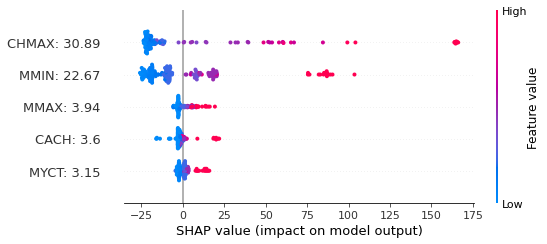

ShapFeatureSelector(X=               vendor name  Model Name  MYCT   MMIN  MMAX  CACH  CHMIN  CHMAX
cdc          cyber:170/845          64  5240  20970    30    12     24    208
c.r.d      universe:68/137         320   512   5000     4     1      5     77
cambex             1641-11          50  2000  16000     8     3      6     52
ibm                4341-12         185  2000  16000    16     1      6     76
ibm                 3083:e          26  8000  16000     0     8     16    185
...                    ...         ...   ...    ...   ...   ...    ...    ...
ibm                   38/8         400  4000   8000     0     1      1     32
bti                   5000         350    64     64     0     1      4     10
honeywell         dps:8/20         140  2000   4000     8     1     20     22
prime            50-750-ii         160  1000   8000...
                    study=<optuna.study.study.Study object at 0x11110e860>,
                    study_optimize_catch=(),
                    study_optimize_gc_after_trial=False,
                    study_optimize_n_jobs=-1,
                    study_optimize_objective_n_trials=20,
                    study_optimize_objective_timeout=600,
                    study_optimize_show_progress_bar=False, test_size=0.3,
                    verbose=10,
                    y=           PRP
cdc        136
c.r.d       28
cambex      74
ibm         76
ibm        113
...        ...
ibm         45
bti         15
honeywell   32
prime       43
ibm         18

[140 rows x 1 columns])

In [8]:
ShapFeatureSelector.shap_feature_selector_factory.plot_features_all(
    type_of_plot="summary_plot",
    path_to_save_plot="../plots/shap_optuna_search_regression_summary_plot"
)


#### Check performance of the Pipeline

In [9]:
print('r2 score : ')
print(r2_score(y_test,y_pred))


r2 score : 
0.9199440731541862


#### Get access to feature selector instance

In [10]:
print(ShapFeatureSelector.shap_feature_selector_factory.get_feature_selector_instance())